In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspedas

from Helper.mva import mva
from Helper.plotting import plot_variables_from_sections, plot_crossing_radius, plot_omni_data, load_position_data, plot_shue_radius
from Helper.silence import silence_all
from Helper.shue_model import filter_train_samples_by_time
from data_loader import MagnetotailDataset
from double_transformer_multi import DoubleTransformerMulti

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# TRAINING DATASET
file_path = Path('..') / "Data" / "training_data" / "artemis_P1_v4.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)

dataset.set_regions_for_sections(overwrite=False, filepath='regions_artemis_P1_v4/section_to_region_map_non_strict.npz')

# Get the trainable samples from the dataset
train_samples = dataset.get_trainable_samples()

# Use only samples after a certain time
boundary_time = np.datetime64('2012-08-29T00:00:00.000000000', 'ns')

# Apply the function
accuracy_samples = filter_train_samples_by_time(train_samples, dataset, boundary_time, method='more_than', data_origin_exclude_always='Themis_C')

Setting trainable samples for each section...


100%|██████████| 162/162 [00:00<00:00, 228.61it/s]


Computing plasma beta for each section...


100%|██████████| 162/162 [00:03<00:00, 41.23it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 162/162 [00:00<00:00, 35869.57it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 162/162 [00:00<00:00, 162050.38it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 162/162 [00:00<00:00, 64435.96it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 162/162 [00:00<00:00, 162944.18it/s]


In [4]:
# Analysis DATASET
file_path = Path('..') / "Data" / "training_data" / "artemis_P1_v2_high_sampling.h5"
abs_file_path = file_path.resolve()

# Create dataset
mva_dataset = MagnetotailDataset(abs_file_path)

# Get the samples from the dataset
mva_samples = mva_dataset.get_trainable_samples()

# Use only samples after a certain time
boundary_time = np.datetime64('2012-08-29T00:00:00.000000000', 'ns')

# Apply the function
mva_samples = filter_train_samples_by_time(mva_samples, mva_dataset, boundary_time, method='more_than')

Setting trainable samples for each section...


100%|██████████| 83/83 [00:00<00:00, 90.33it/s] 


Computing plasma beta for each section...


100%|██████████| 83/83 [00:11<00:00,  7.39it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 83/83 [00:00<00:00, 41552.55it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 83/83 [00:00<00:00, 20630.98it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 83/83 [00:00<00:00, 18428.21it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 83/83 [00:00<00:00, 83184.52it/s]


In [5]:
# Analysis DATASET
file_path = Path('..') / "Data" / "testing_data" / "artemis_P1_v4.h5"
abs_file_path = file_path.resolve()

# Create dataset
analysis_dataset = MagnetotailDataset(abs_file_path)

# Get the samples from the dataset
analysis_samples = analysis_dataset.get_trainable_samples()

# Use only samples after a certain time
boundary_time = np.datetime64('2012-08-29T00:00:00.000000000', 'ns')

# Apply the function
analysis_samples = filter_train_samples_by_time(analysis_samples, analysis_dataset, boundary_time, method='more_than')

Setting trainable samples for each section...


100%|██████████| 32/32 [00:00<00:00, 137.13it/s]


Computing plasma beta for each section...


100%|██████████| 32/32 [00:02<00:00, 13.56it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 32/32 [00:00<00:00, 32094.15it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 32/32 [00:00<00:00, 21200.08it/s]


Computing ion velocity magnitude for each section...


100%|██████████| 32/32 [00:00<00:00, 31752.48it/s]


Extracting ion velocity x-component for each section...


100%|██████████| 32/32 [00:00<?, ?it/s]


In [6]:
analysis_samples.keys()

dict_keys(['section_018', 'section_019', 'section_020', 'section_021', 'section_022', 'section_023', 'section_024', 'section_025', 'section_026', 'section_027', 'section_028', 'section_029', 'section_030', 'section_031'])

In [7]:
# Read crossing times from Excel file

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()

# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -7 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [8]:
data_types = ['ion_eflux', 'ion_avgtemp', 'ion_density', 'ion_velocity_magnitude']

# Create and load model (standard model parameters for all provided models)
model = DoubleTransformerMulti(
    input_dim                   = 31,
    timestamps                  = 1, # Adapt to model used
    d_model                     = 64,
    nhead                       = 2,
    num_encoder_layers          = 2,
    num_decoder_layers          = 2,
    dim_feedforward             = 64,
    mask_ratio                  = 0.4,
    patches_per_timestamp_spect = 8,
    n_vectors                   = 0,
    n_scalars                   = 3,
    data_types                  = data_types,
    device                      = 'cuda' if torch.cuda.is_available() else 'cpu'
)

model.load_models('models/1_step_velocity/tail_avg3_non_strict.pth', 'models/1_step_velocity/sheath_avg3_non_strict.pth')


Padding input_dim from 31 to 32 to make it divisible by 8
Created 70 deterministic noise patterns for single timestamp
Padding input_dim from 31 to 32 to make it divisible by 8


In [9]:
model.evaluate_accuracy(accuracy_samples)

Skipping section section_095 with unknown region None.


28-Oct-25 17:42:43: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(



Skipping section section_101 with unknown region None.
Skipping section section_103 with unknown region None.
Skipping section section_105 with unknown region None.
Skipping section section_119 with unknown region None.
Skipping section section_120 with unknown region None.
Skipping section section_123 with unknown region None.
Skipping section section_128 with unknown region None.
Skipping section section_129 with unknown region None.
Skipping section section_130 with unknown region None.
Skipping section section_157 with unknown region None.


(0.999398586678695,
 {'magnetotail': {'precision': 0.9991836734693877,
   'recall': 1.0,
   'f1-score': 0.9995916700694161,
   'support': 4896.0},
  'magnetosheath': {'precision': 1.0,
   'recall': 0.9977207977207977,
   'f1-score': 0.9988590986879635,
   'support': 1755.0},
  'accuracy': 0.999398586678695,
  'macro avg': {'precision': 0.9995918367346939,
   'recall': 0.9988603988603988,
   'f1-score': 0.9992253843786898,
   'support': 6651.0},
  'weighted avg': {'precision': 0.999399077628345,
   'recall': 0.999398586678695,
   'f1-score': 0.9993983663896011,
   'support': 6651.0}})

In [10]:
model.evaluate_accuracy(accuracy_samples)

Skipping section section_095 with unknown region None.
Skipping section section_101 with unknown region None.
Skipping section section_103 with unknown region None.
Skipping section section_105 with unknown region None.
Skipping section section_119 with unknown region None.
Skipping section section_120 with unknown region None.
Skipping section section_123 with unknown region None.
Skipping section section_128 with unknown region None.
Skipping section section_129 with unknown region None.
Skipping section section_130 with unknown region None.
Skipping section section_157 with unknown region None.


(0.999398586678695,
 {'magnetotail': {'precision': 0.9991836734693877,
   'recall': 1.0,
   'f1-score': 0.9995916700694161,
   'support': 4896.0},
  'magnetosheath': {'precision': 1.0,
   'recall': 0.9977207977207977,
   'f1-score': 0.9988590986879635,
   'support': 1755.0},
  'accuracy': 0.999398586678695,
  'macro avg': {'precision': 0.9995918367346939,
   'recall': 0.9988603988603988,
   'f1-score': 0.9992253843786898,
   'support': 6651.0},
  'weighted avg': {'precision': 0.999399077628345,
   'recall': 0.999398586678695,
   'f1-score': 0.9993983663896011,
   'support': 6651.0}})

In [11]:
# Use validation samples to get results and score
results = model.get_results(analysis_samples, crossing_times=crossing_times_ns, window_average_errors=3)
score = model.get_model_score(results, time_window_minutes=30, method='hungarian')
score['dataframe']

,Metric,Relative,Normalized,Absolute
0,True Positive Rate,0.389,0.447,0.487
1,False Positive Rate,0.367,0.158,0.339
2,False Negative Rate,0.611,0.553,0.513
3,True Positives,88,101,111
4,In Range Positives,111,126,133
5,Out Range Predicted Positives,50,17,57
6,False Positives,51,19,57
7,False Negatives,138,125,117
8,Precision,0.633,0.842,0.661
9,F1 Score,0.482,0.584,0.561


In [12]:
crossing_times_detected = results['zero_crossing_times_normalized']
# start_time='2013-04-27T16:00:00', end_time='2013-04-28T02:00:00'
# start_time='2013-05-25T20:00:00', end_time='2013-05-26T07:00:00'

In [13]:
data_types = ['ion_eflux', 'ion_avgtemp', 'ion_density', 'ion_velocity_magnitude']

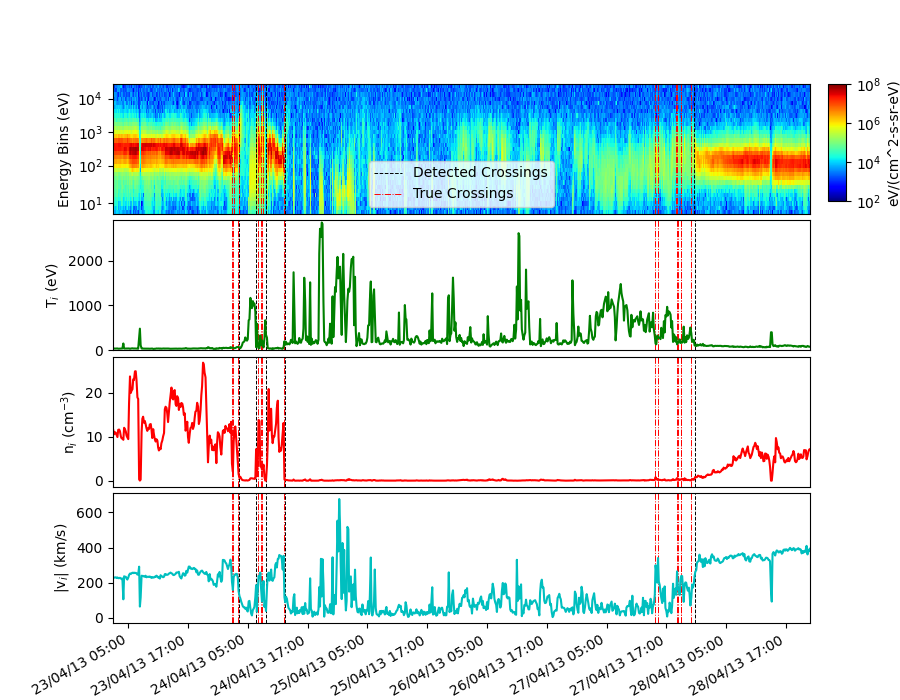

In [14]:
data = plot_variables_from_sections(analysis_samples['section_028'], data_types, hour_interval=12,  crossing_times=crossing_times_detected, crossing_times_true=crossing_times_ns,  title=None, logscale=False, figsize=(9, 7))

28-Oct-25 17:43:45: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Helper\plotting.py:329: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()



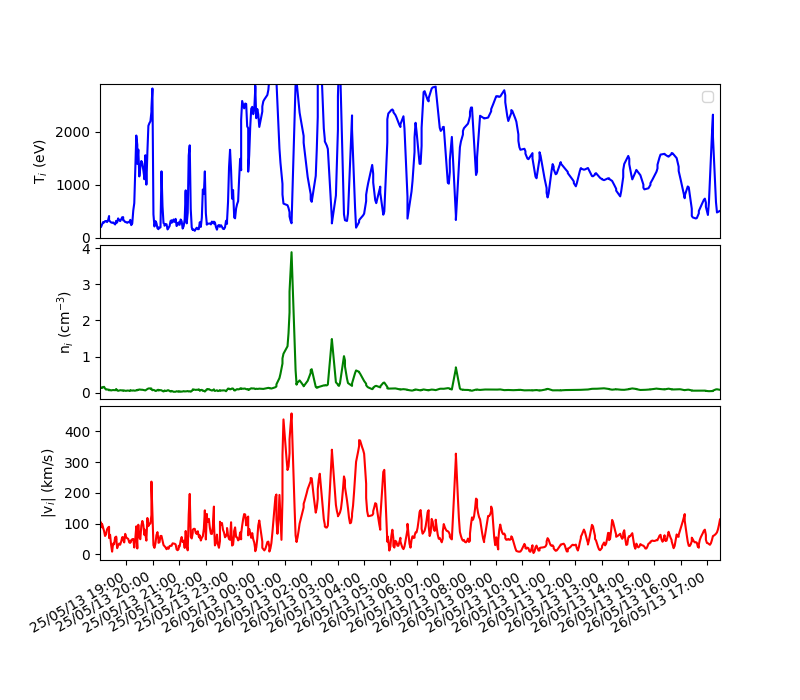

In [15]:

data = plot_variables_from_sections(mva_samples['section_080'], data_types[1:], start_time='2013-05-25T18:00:00', end_time='2013-05-29T13:00:00', hour_interval=1, crossing_times=crossing_times_detected, crossing_times_true=crossing_times_ns,  title=None, logscale=False, figsize=(8, 7))

In [16]:
import pyspedas
from pytplot import tplot  
from pyspedas import get_data
import numpy as np
import matplotlib.pyplot as plt
variables = pyspedas.projects.omni.data(trange=['2013-05-20', '2013-05-30'],  datatype='5min')

28-Oct-25 17:43:45: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2013/
28-Oct-25 17:43:47: File is current: omni_data/hro_5min/2013/omni_hro_5min_20130501_v01.cdf


In [17]:
cdaweb_obj = pyspedas.CDAWeb()
dataset_list = cdaweb_obj.get_datasets(['ARTEMIS'], ['Magnetic Fields (space)', 'Particles (space)'])

In [18]:
variables

['IMF',
 'PLS',
 'IMF_PTS',
 'PLS_PTS',
 'percent_interp',
 'Timeshift',
 'RMS_Timeshift',
 'Time_btwn_obs',
 'F',
 'BX_GSE',
 'BY_GSE',
 'BZ_GSE',
 'BY_GSM',
 'BZ_GSM',
 'RMS_SD_B',
 'RMS_SD_fld_vec',
 'flow_speed',
 'Vx',
 'Vy',
 'Vz',
 'proton_density',
 'T',
 'Pressure',
 'E',
 'Beta',
 'Mach_num',
 'Mgs_mach_num',
 'x',
 'y',
 'z',
 'BSN_x',
 'BSN_y',
 'BSN_z',
 'AE_INDEX',
 'AL_INDEX',
 'AU_INDEX',
 'SYM_D',
 'SYM_H',
 'ASY_D',
 'ASY_H',
 'PC_N_INDEX',
 'PR-FLX_10',
 'PR-FLX_30',
 'PR-FLX_60']

In [19]:

urllist = cdaweb_obj.get_filenames(['THB_L2_FGM (2007-03-07 to 2025-09-21)'],'2013-06-26', '2013-06-27')
variables_magf = cdaweb_obj.cda_download(urllist, "cdaweb/")
urllist = cdaweb_obj.get_filenames(['THB_L2_ESA (2007-03-07 to 2025-09-21)'],'2013-06-26', '2013-06-27')
variables = cdaweb_obj.cda_download(urllist, "cdaweb/")
urllist = cdaweb_obj.get_filenames(['THB_OR_SSC (2007-02-24 to 2025-08-31)'],'2013-06-26', '2013-06-27')
variables_sc = cdaweb_obj.cda_download(urllist, "cdaweb/")

28-Oct-25 17:43:52: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\l2\fgm\2013\thb_l2_fgm_20130626_v01.cdf
28-Oct-25 17:43:53: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\l2\fgm\2013\thb_l2_fgm_20130627_v01.cdf
28-Oct-25 17:43:53: Downloaded 2 CDF files.
28-Oct-25 17:43:55: Number of tplot variables loaded:17
28-Oct-25 17:43:56: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\l2\esa\2013\thb_l2_esa_20130626_v01.cdf
28-Oct-25 17:43:57: File is current: C:\Users\ianma\OneDrive\Thesis\Magnetotail-Boundary-with-ML\Training\cdaweb\themis\thb\l2\esa\2013\thb_l2_esa_20130627_v01.cdf
28-Oct-25 17:43:57: Downloaded 2 CDF files.
28-Oct-25 17:43:57: Variable thb_peer_symm_angQ not marked as VIRTUAL, but has FUNCT and COMPONENT_0 attributes; skipping
28-Oct-25 17:43:57: Variable thb_peer_magfQ not marked as VIRTUAL, but has FUN

In [311]:
magnetic_field = get_data('thb_fgs_gsm')
ion_density = get_data('thb_peir_density')
ion_velocity = get_data('thb_peif_velocity_gsm')
ion_temperature = get_data('thb_peir_avgtemp')
ion_velocity_thermal = get_data('thb_peir_vthermal')
spacecraft_position = get_data('XYZ_GSM')


In [314]:
mask = (magnetic_field.times.astype('datetime64[s]') > np.datetime64('2013-06-26T07:45:00')) & (magnetic_field.times.astype('datetime64[s]') < np.datetime64('2013-06-26T08:55:00'))
magnetic_field_times = magnetic_field.times[mask]
magnetic_field_values = magnetic_field.y[mask]
mask = (ion_velocity.times.astype('datetime64[s]') > np.datetime64('2013-06-26T07:45:00')) & (ion_velocity.times.astype('datetime64[s]') < np.datetime64('2013-06-26T08:55:00'))
ion_velocity_values = ion_velocity.y[mask]
ion_vecolity_times = ion_velocity.times[mask]
mask = (ion_density.times.astype('datetime64[s]') > np.datetime64('2013-06-26T07:45:00')) & (ion_density.times.astype('datetime64[s]') < np.datetime64('2013-06-26T08:55:00'))
ion_density_values = ion_density.y[mask]
ion_temperature_values = ion_temperature.y[mask]
ion_times = ion_temperature.times[mask]
mask = (spacecraft_position.times.astype('datetime64[s]') > np.datetime64('2013-06-26T07:45:00')) & (spacecraft_position.times.astype('datetime64[s]') < np.datetime64('2013-06-26T08:55:00'))
spacecraft_position_values = spacecraft_position.y[mask]
spacecraft_times = spacecraft_position.times[mask]

In [137]:
import numpy as np
from Helper.walen_test import walen_simple

res = walen_simple(magnetic_field_values, ion_velocity_values, ion_density_values, demean=True)
res

AssertionError: n must be scalar or length N

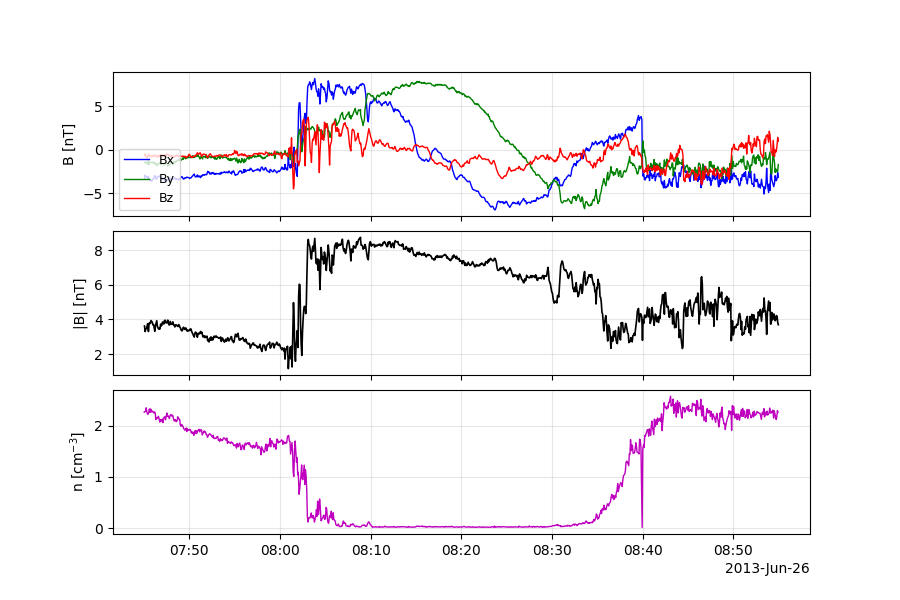

In [320]:
import numpy as np
import matplotlib.pyplot as plt

# Components (note: your array columns look like Bz, By, Bx in that order)
bx_gsm_thb = magnetic_field_values[:, 0]
by_gsm_thb = magnetic_field_values[:, 1]
bz_gsm_thb = magnetic_field_values[:, 2]

ion_velocity_magnitude = np.linalg.norm(ion_velocity_values, axis=1) 

# Magnitude
bmag = np.sqrt(bx_gsm_thb**2 + by_gsm_thb**2 + bz_gsm_thb**2)

# Times
times = magnetic_field_times.astype('datetime64[s]')
ion_times = ion_times.astype('datetime64[s]')

# --- PLOTTING ---
fig, axes = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
plt.subplots_adjust(hspace=0.10)

# Magnetic field components
axes[0].plot(times, bx_gsm_thb, 'b-', linewidth=1, label='Bx')
axes[0].plot(times, by_gsm_thb, 'g-', linewidth=1, label='By')
axes[0].plot(times, bz_gsm_thb, 'r-', linewidth=1, label='Bz')
axes[0].set_ylabel('B [nT]')
axes[0].legend(loc='lower left', ncol=1, fontsize=9)
axes[0].grid(True, alpha=0.3)

# Magnetic field magnitude
axes[1].plot(times, bmag, 'k-', linewidth=1.2)
axes[1].set_ylabel('|B| [nT]')
# axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

# Ion density
axes[2].plot(ion_times, ion_density_values, 'm-', linewidth=1)
axes[2].set_ylabel('n [cm$^{-3}$]')
# axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

# Ion temperature
# axes[3].plot(ion_times, ion_temperature_values, 'c-', linewidth=1)
# axes[3].set_ylabel('T [eV]')
# axes[3].grid(True, alpha=0.3)

# Ion velocity magnitude
# axes[4].plot(ion_times, ion_velocity_magnitude, 'orange', linewidth=1)
# axes[4].set_ylabel('|V| [km/s]')
# axes[4].grid(True, alpha=0.3)

# Ion velocity X 
# axes[3].plot(ion_vecolity_times.astype('datetime64[s]'), ion_velocity_values[:, 0], 'orange', linewidth=1)
# axes[3].set_ylabel('Vx [km/s]')
# axes[3].grid(True, alpha=0.3)

plt.show()

# # Spacecraft position Z position
# axes[4].plot(spacecraft_times.astype('datetime64[s]'), spacecraft_position_values[:, 2], 'purple', linewidth=1)
# axes[4].set_ylabel('Z [Re]')
# axes[4].grid(True, alpha=0.3)

# Plot in every ax, a vertical dashed black line at 26-05-2013 01:09 and 26-05-2013 01:19
# for ax in axes:
#     ax.axvline(np.datetime64('2013-05-26T01:09:00'), color='black', linestyle='--', linewidth=1)
#     ax.axvline(np.datetime64('2013-05-26T01:19:00'), color='black', linestyle='--', linewidth=1)

# # Spacecraft position Y position
# axes[6].plot(spacecraft_times.astype('datetime64[s]'), spacecraft_position_values[:, 1], 'purple', linewidth=1)
# axes[6].set_ylabel('Y [Re]')
# axes[6].grid(True, alpha=0.3)





λ ratios (L/M, M/N): (2.193403688394027, 22.7612991043006)
N (normal): [-0.09486331  0.1106318  -0.98932379]


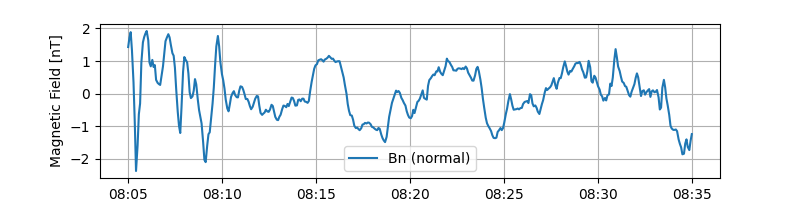

In [311]:
res = mva(magnetic_field_values)
Bl, Bm, Bn = res.B_lmn.T
print("λ ratios (L/M, M/N):", res.lambda_ratios)
print("N (normal):", res.N)             # unit normal in GSM coords
plt.figure(figsize=(8, 2))
plt.plot(magnetic_field_times.astype('datetime64[s]'), Bn, label='Bn (normal)')
# plt.plot(data['times'], Bm, 'g', label='Bm (intermediate)')
# plt.plot(data['times'], Bl, 'r', label='Bl (maximum variance)')
plt.xlabel('Time')
plt.ylabel('Magnetic Field [nT]')
plt.legend()
plt.grid()
plt.show()

28-Oct-25 18:05:47: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(



NameError: name 'Bl' is not defined

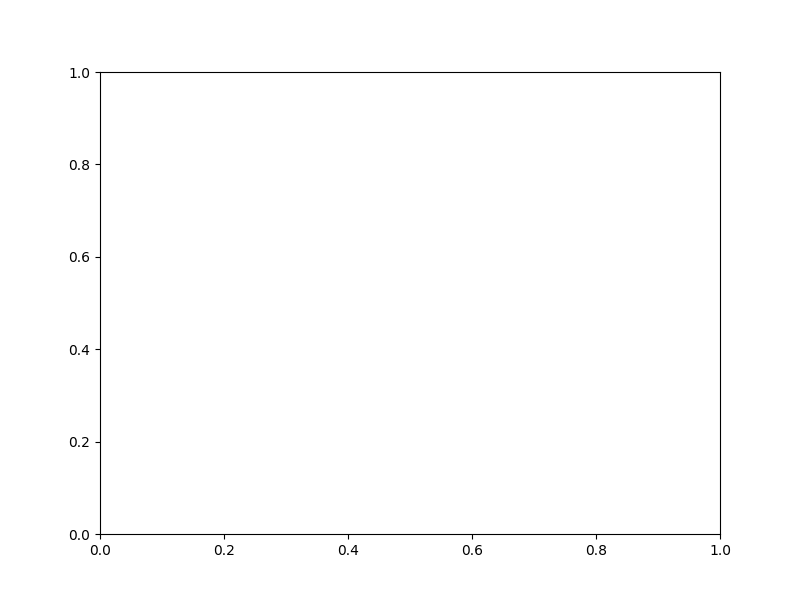

In [20]:
# Hodogram with time progression using color and connected line
fig, ax = plt.subplots(figsize=(8, 6))

# Create a color map based on time progression using a clearer colormap
time_values = np.linspace(0, 1, len(Bl))
colors = plt.cm.brg(time_values)

# Plot the connected line first
ax.plot(Bl, Bm, color='lightgray', alpha=0.7, linewidth=2, zorder=1)

# Plot the hodogram with color progression
scatter = ax.scatter(Bl, Bm, c=time_values, cmap='brg', s=25, alpha=0.8, zorder=2)

# Add start and end markers
ax.scatter(Bl[0], Bm[0], color='red', s=50, marker='s', label='Start', zorder=3)
ax.scatter(Bl[-1], Bm[-1], color='blue', s=50, marker='^', label='End', zorder=3)

# Add colorbar at the bottom with time ticks
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.15, shrink=0.65)

# Create time ticks for colorbar - convert to datetime and format as 1 hour intervals
start_time = magnetic_field_times[0]
end_time = magnetic_field_times[-1]
total_duration = (pd.to_datetime(end_time.astype('datetime64[ns]')) - pd.to_datetime(start_time.astype('datetime64[ns]'))).total_seconds() / 3600 # hours

# Create 1-hour interval ticks
num_ticks = (int(total_duration) + 1)*5
time_range = np.linspace(0, 1, num_ticks)
time_indices = (time_range * (len(magnetic_field_times) - 1)).astype(int)
time_labels = [pd.to_datetime(magnetic_field_times[i].astype('datetime64[s]')).strftime('%H:%M') for i in time_indices]

cbar.set_ticks(time_range)
cbar.set_ticklabels(time_labels)
cbar.ax.tick_params(rotation=45)
cbar.set_label('Time Progression', labelpad=10)

ax.set_xlabel('B_L [nT]')
ax.set_ylabel('B_M [nT]')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [35]:
bz_gsm = pyspedas.get_data('BZ_GSM')
by_gsm = pyspedas.get_data('BY_GSM')
bx_gsm = pyspedas.get_data('BX_GSE')

23-Sep-25 15:37:04: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(



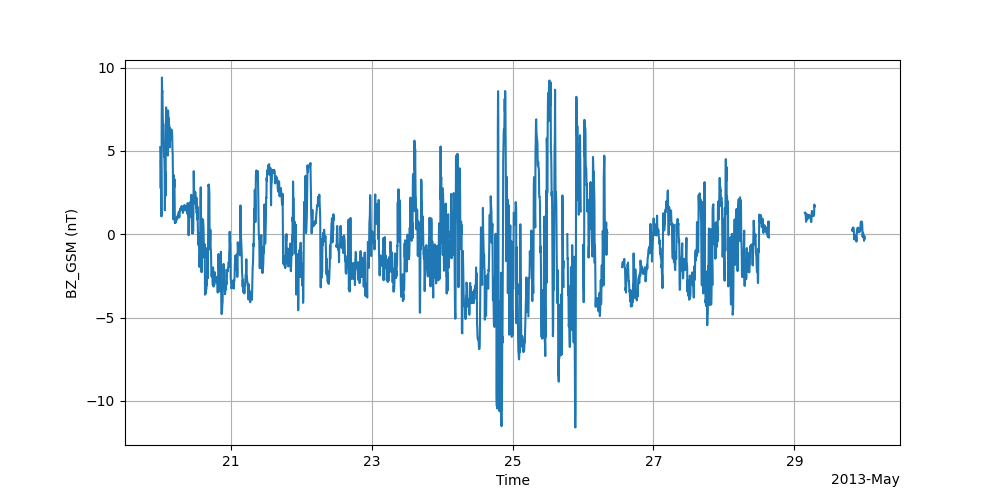

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(bz_gsm.times.astype("datetime64[s]"), bz_gsm.y)
plt.ylabel('BZ_GSM (nT)')
plt.xlabel('Time')
plt.grid()
plt.show()

λ ratios (L/M, M/N): (2.855079456411987, 2.252212367898336)
N (normal): [-0.60093169  0.30901251  0.73715153]


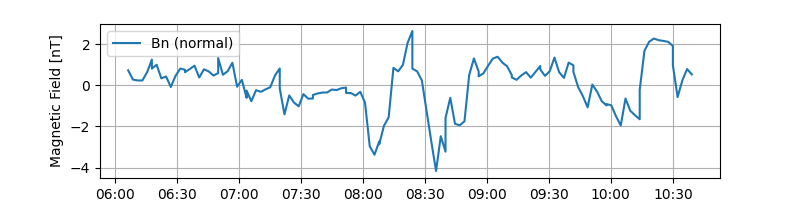

In [63]:

res = mva(data['magnetic_field_gsm'])
Bl, Bm, Bn = res.B_lmn.T
print("λ ratios (L/M, M/N):", res.lambda_ratios)
print("N (normal):", res.N)             # unit normal in GSM coords
plt.figure(figsize=(8, 2))
plt.plot(data['times'], Bn, label='Bn (normal)')
# plt.plot(data['times'], Bm, 'g', label='Bm (intermediate)')
# plt.plot(data['times'], Bl, 'r', label='Bl (maximum variance)')
plt.xlabel('Time')
plt.ylabel('Magnetic Field [nT]')
plt.legend()
plt.grid()
plt.show()

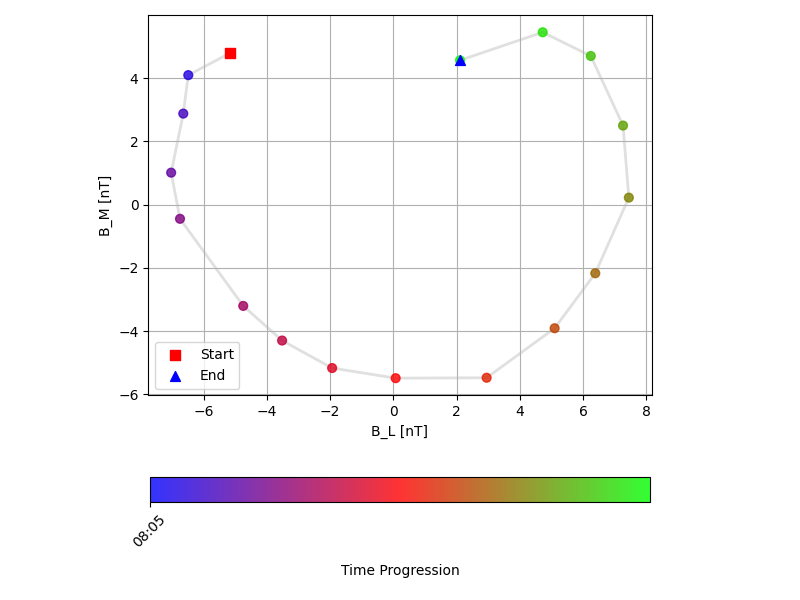

In [32]:
# Hodogram with time progression using color and connected line
fig, ax = plt.subplots(figsize=(8, 6))

# Create a color map based on time progression using a clearer colormap
time_values = np.linspace(0, 1, len(Bl))
colors = plt.cm.brg(time_values)

# Plot the connected line first
ax.plot(Bl, Bm, color='lightgray', alpha=0.7, linewidth=2, zorder=1)

# Plot the hodogram with color progression
scatter = ax.scatter(Bl, Bm, c=time_values, cmap='brg', s=40, alpha=0.8, zorder=2)

# Add start and end markers
ax.scatter(Bl[0], Bm[0], color='red', s=50, marker='s', label='Start', zorder=3)
ax.scatter(Bl[-1], Bm[-1], color='blue', s=50, marker='^', label='End', zorder=3)

# Add colorbar at the bottom with time ticks
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.15, shrink=0.65)

# Create time ticks for colorbar - convert to datetime and format as 1 hour intervals
start_time = data['times'][0]
end_time = data['times'][-1]
total_duration = (pd.to_datetime(end_time) - pd.to_datetime(start_time)).total_seconds() / 3600  # hours

# Create 1-hour interval ticks
num_ticks = int(total_duration) + 1
time_range = np.linspace(0, 1, num_ticks)
time_indices = (time_range * (len(data['times']) - 1)).astype(int)
time_labels = [pd.to_datetime(data['times'][i]).strftime('%H:%M') for i in time_indices]

cbar.set_ticks(time_range)
cbar.set_ticklabels(time_labels)
cbar.ax.tick_params(rotation=45)
cbar.set_label('Time Progression', labelpad=10)

ax.set_xlabel('B_L [nT]')
ax.set_ylabel('B_M [nT]')
ax.grid(True)
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


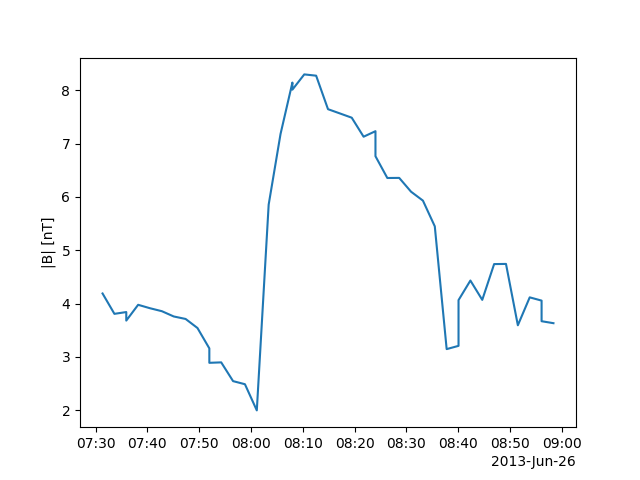

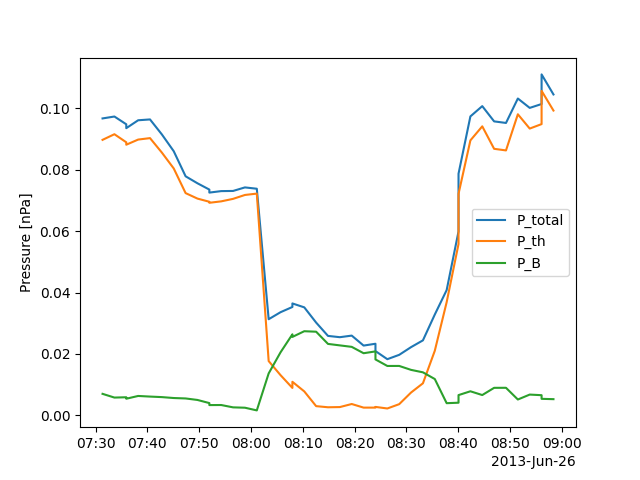

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs
B_nT = np.linalg.norm(data['magnetic_field_gsm'], axis=1)   # |B| in nT
n_cm3 = data['ion_density']                                 # in cm^-3
Ti_eV = data['ion_avgtemp']                             # in eV
Te_eV = Ti_eV                                               # assume Te ~ Ti (change if you have Te)

# Constants
mu0 = 4e-7*np.pi                      # H/m
kB_eV = 1.602176634e-19               # J/eV
nPa = 1e9                             # Pa -> nPa

# Unit conversions
B_T  = B_nT * 1e-9                    # tesla
n_m3 = n_cm3 * 1e6                    # m^-3

# Pressures
PB_Pa  = B_T**2 / (2*mu0)             # magnetic pressure [Pa]
Pth_Pa = n_m3 * kB_eV * (Ti_eV + Te_eV)   # thermal pressure [Pa]

PB_nPa  = PB_Pa  * nPa
Pth_nPa = Pth_Pa * nPa
Ptot_nPa = PB_nPa + Pth_nPa

# Optional: plasma beta
beta = Pth_Pa / PB_Pa

# Plots
plt.figure()
plt.plot(data['times'], Ptot_nPa, label='P_total')
plt.plot(data['times'], Pth_nPa, label='P_th')
plt.plot(data['times'], PB_nPa,  label='P_B')
plt.ylabel('Pressure [nPa]')
plt.legend()

plt.figure()
plt.plot(data['times'], B_nT)
plt.ylabel('|B| [nT]')
plt.show()

In [34]:
load_position_data(analysis_samples)

14it [00:00, ?it/s]


12it [00:00, 53.87it/s]

No crossing times found within section time range.
No crossing times found within section time range.


14it [00:00, 47.20it/s]


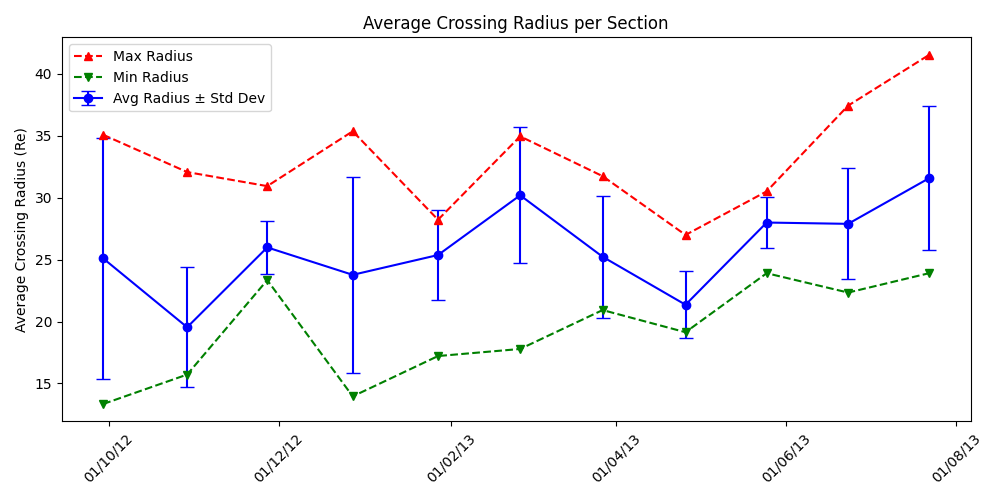

In [98]:
_ = plot_crossing_radius(crossing_times_detected, analysis_samples, satellite_name='THB', figsize=(10, 5))

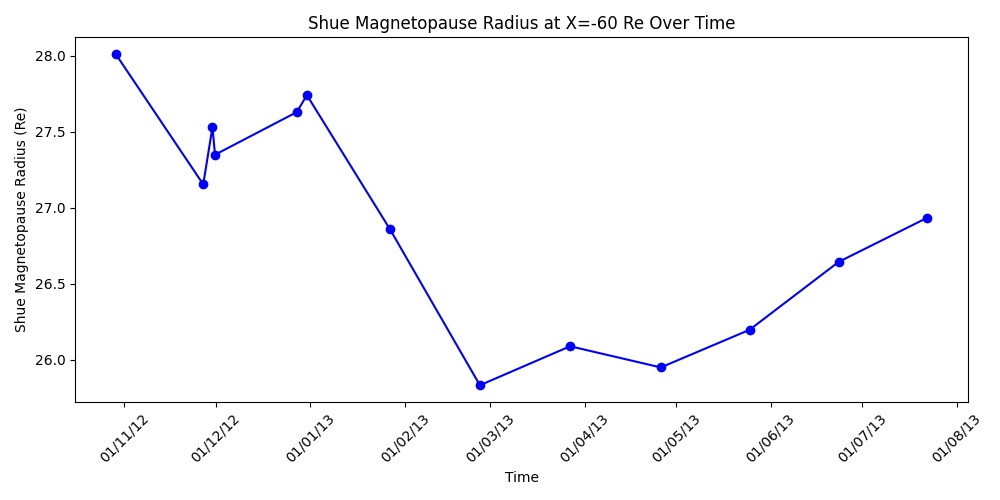

In [102]:
plot_shue_radius(-60, sections=analysis_samples)

In [343]:
plot_omni_data('2012-10-01', '2013-08-01', sections=analysis_samples)

KeyboardInterrupt: 

In [5]:
# Read crossing times from Excel file

file_path = Path('..') / "Results" / "Results_to_plot_v2.csv"
abs_file_path = file_path.resolve()

# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_csv(abs_file_path)

df

,Model,Window Average Error,True Positives,In range Positives,False Positives,Precision,F1 Score,TP_mean,TP_std,TP_absolute,Recall,F0.5 Score
0,1_steps_velocity_avg5,3,87,118,17,0.837,0.530,30,8.07,6.63,0.387771,0.679550
1,1_steps_velocity_avg5,2,92,122,18,0.836,0.549,30,8.56,5.96,0.408695,0.691419
2,1_steps_velocity_avg3,3,111,139,25,0.816,0.617,30,6.93,6.17,0.496032,0.722756
3,2_steps_velocity_avg5,1,91,121,21,0.812,0.540,30,9.43,7.63,0.404502,0.675832
4,3_steps_velocity_avg5,3,78,112,18,0.812,0.488,30,7.67,5.89,0.348817,0.641606
5,2_steps_velocity_avg5,2,89,120,21,0.809,0.531,30,9.46,7.62,0.395197,0.668918
6,2_steps_velocity_avg5,3,87,119,21,0.806,0.521,30,10.06,8.25,0.384900,0.661301
7,2_steps_velocity_avg4,3,94,124,24,0.797,0.545,30,8.04,6.52,0.414075,0.672600
8,4_steps_velocity_avg5,3,78,110,20,0.796,0.479,30,8.04,6.16,0.342573,0.629389
9,3_steps_velocity_avg5,1,84,118,22,0.792,0.508,30,7.74,6.07,0.373918,0.647259


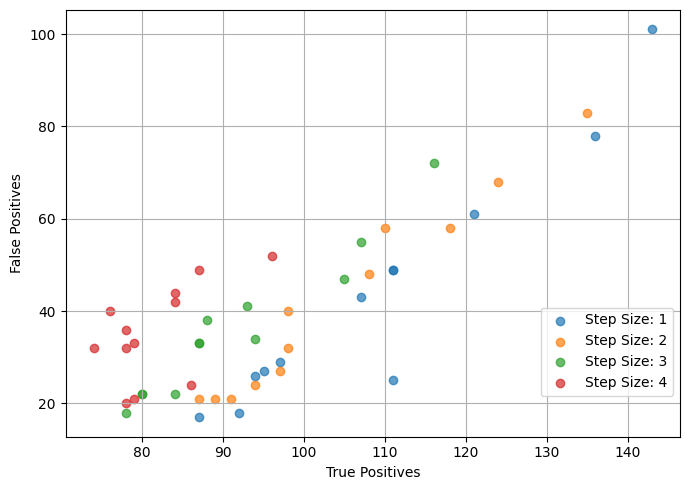

In [6]:
import pandas as pd

# ROC style plot with connected points
fig, ax = plt.subplots(figsize=(7, 5))

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels_added = set()  # Track which labels we've already added

# Sort the dataframe by step size to ensure consistent ordering
df_sorted = df.copy()
df_sorted['step_size_num'] = df_sorted['Model'].str.split('_').str[0].astype(int)
df_sorted = df_sorted.sort_values('step_size_num')

# # Group by step size and window average data for connecting lines
# for step_size in ['1', '2', '3', '4']:
#     step_data = df_sorted[df_sorted['step_size_num'] == int(step_size)]
    
#     # Group by window average data within each step size
#     for avg_data in step_data['Model'].str.split('_').str[-1].str[-1].unique():
#         subset = step_data[step_data['Model'].str.split('_').str[-1].str[-1] == avg_data]
        
#         if len(subset) > 1:  # Only draw lines if there are multiple points
#             # Sort by window average error for proper line connection
#             subset = subset.sort_values('Window Average Error')
            
#             # Draw connecting line
#             ax.plot(subset['True Positives'], subset['False Positives'], 
#                    color=color[int(step_size)-1], linestyle='dashed', alpha=0.3, linewidth=1)

# Plot individual points (same as before)
for i in range(len(df_sorted)):
    # Get model step size
    step_size = df_sorted.iloc[i]['Model'].split('_')[0]

    # Model averaging error
    average_error = str(df_sorted.iloc[i]['Window Average Error'])

    # Average data
    averaging_window_data = str(df_sorted.iloc[i]['Model'].split('_')[-1][-1])

    text = 'd: ' + averaging_window_data + ', ' + 'ε:' + average_error
    # Only add label if we haven't seen this step size before
    label = f'Step Size: {step_size}' if step_size not in labels_added else ""
    if step_size not in labels_added:
        labels_added.add(step_size)
    
    ax.scatter(df_sorted.iloc[i]['True Positives'], df_sorted.iloc[i]['False Positives'], 
              color=color[int(step_size)-1], label=label, alpha=0.7)
    # ax.text(df_sorted.iloc[i]['True Positives'], df_sorted.iloc[i]['False Positives'], 
    #        text, fontsize=8, va='bottom', ha='center')

ax.set_xlabel('True Positives')
ax.set_ylabel('False Positives')

# Force legend to appear in lower right corner
legend1 = ax.legend(loc='lower right' , bbox_to_anchor=(1, 0.08))

# # Add text explanation for annotations
# ax.text(0.7555, 0.07, ' d:  Window Average Data \n ε:  Window Average Error', 
#     transform=ax.transAxes, fontsize=10, verticalalignment='top',
#     bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))

ax.grid(True)
plt.tight_layout()
plt.show()

25-Sep-25 17:59:09: c:\Users\ianma\miniconda3\envs\deep_learning\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(



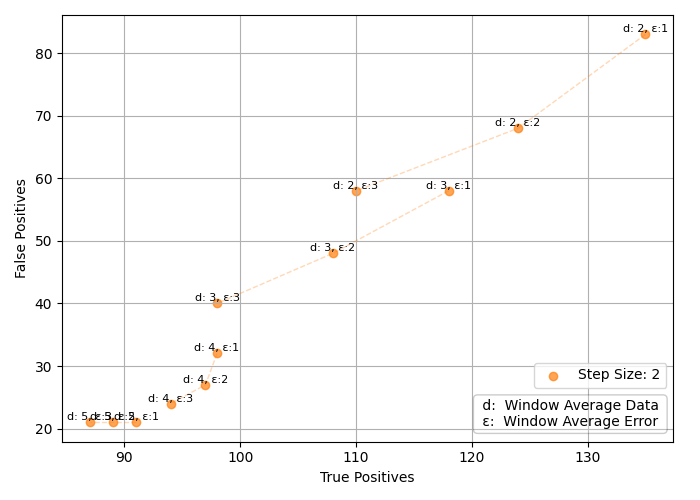

In [354]:
# ROC style plot for step size 2 only
fig, ax = plt.subplots(figsize=(7, 5))

# Filter dataframe for step size 2 only
df_step2 = df[df['Model'].str.startswith('2_')]
df_step2 = df_step2.copy()
df_step2['step_size_num'] = 2
df_step2 = df_step2.sort_values('Window Average Error')

# Group by window average data for connecting lines
for avg_data in df_step2['Model'].str.split('_').str[-1].str[-1].unique():
    subset = df_step2[df_step2['Model'].str.split('_').str[-1].str[-1] == avg_data]
    
    if len(subset) > 1:  # Only draw lines if there are multiple points
        # Sort by window average error for proper line connection
        subset = subset.sort_values('Window Average Error')
        
        # Draw connecting line
        ax.plot(subset['True Positives'], subset['False Positives'], 
               color='tab:orange', linestyle='dashed', alpha=0.3, linewidth=1)

# Plot individual points
for i in range(len(df_step2)):
    # Model averaging error
    average_error = str(df_step2.iloc[i]['Window Average Error'])
    
    # Average data
    averaging_window_data = str(df_step2.iloc[i]['Model'].split('_')[-1][-1])
    
    text = 'd: ' + averaging_window_data + ', ' + 'ε:' + average_error
    label = 'Step Size: 2' if i == 0 else ""  # Only label first point
    
    ax.scatter(df_step2.iloc[i]['True Positives'], df_step2.iloc[i]['False Positives'], 
              color='tab:orange', label=label, alpha=0.7)
    ax.text(df_step2.iloc[i]['True Positives'], df_step2.iloc[i]['False Positives'], 
           text, fontsize=8, va='bottom', ha='center')

ax.set_xlabel('True Positives')
ax.set_ylabel('False Positives')
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.11))

# Add text explanation for annotations
ax.text(0.68, 0.1, ' d:  Window Average Data \n ε:  Window Average Error', 
    transform=ax.transAxes, fontsize=10, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))

ax.grid(True)
plt.tight_layout()
plt.show()